<a href="https://colab.research.google.com/github/PomarGN/Proyecto_GCO/blob/main/Masiva_PerfPago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTAR **LIBRERIAS**

In [24]:
#importación de librerías
import matplotlib as mpl         #gráficos
from matplotlib import style     #style package
import matplotlib.pyplot as plt  #gráficos
import seaborn as sns            #gráficos
import pandas as pd              #manipulacion de datos estructurados, tipo serie o frames ("tipo tabla")
import numpy as np               #manipulacion datos estructurados y tipo array ("matriz")
import statsmodels.graphics.tsaplots as sgt #gráfica de autocorrelación
import statsmodels.tsa.stattools as sts #pruebas estadísticas
from statsmodels.tsa.seasonal import seasonal_decompose #descripción TimeSeries
import plotly.express as px
import openpyxl
#fig = px.histogram(data2, x= 'Ingresos', color='Año', title='Histograma - Rango de Ingresos Periodo (2013 - 2016)')
#fig.show()

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **CARGAR BASES**

In [26]:
#--------------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------
#CARGAR DATA SALDO COACTIVA CC-2022
df_sCoactiva_cc22 = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/SaldoCoactiva_CC_2022.csv',encoding='ISO-8859-1')


#--------------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------
# CARGAR DATA MASIVA EMITIDO - CANCELADO - PENDIENTE
df_Masiva22_AP = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/Eva_PerfilPago_Pre_CC.csv',encoding='ISO-8859-1')
df_Masiva22_V = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/Eva_PerfilPago_Veh_CC.csv',encoding='ISO-8859-1')

#Reduciendo la data para no considerar el ultimo registro
ufPPP= len(df_Masiva22_AP['Cod_Contrib'])-1
df_Masiva22_AP= df_Masiva22_AP.iloc[: ufPPP]

ufPPV= len(df_Masiva22_V['Cod_Contrib'])-1
df_Masiva22_V= df_Masiva22_V.iloc[: ufPPV]


#--------------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------
# CARGAR DATA PAGO USO DE TARJETA 2018-2023
df_pagoTarjeta = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/CruceTarjetas.csv',encoding='ISO-8859-1')


#--------------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------
# CARGAR DATA CARTILLAS NOTIFICADAS
df_CartNotif_AP = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/CartillasNotif_Pre-Arb_2023.csv',encoding='ISO-8859-1')
df_CartNotif_V = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/CartillasNotif_Veh_2023.csv',encoding='ISO-8859-1')


#--------------------------------------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------------------------------
# CARGAR DATA DOMICILIO FISCAL
df_domFiscal = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/Data_DomFiscal.csv',encoding='ISO-8859-1')


<ipython-input-26-a03813f9b918>:10: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Masiva22_AP = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/Eva_PerfilPago_Pre_CC.csv',encoding='ISO-8859-1')
<ipython-input-26-a03813f9b918>:11: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Masiva22_V = pd.read_csv('/content/drive/MyDrive/SAT_GCO/DATA COMPARTIDA/SALDOS_PAGOS/Eva_PerfilPago_Veh_CC.csv',encoding='ISO-8859-1')


In [27]:
df_pagoTarjeta.sample(3)

,Etiquetas de fila,Tarjetas
93006,1470636,"American Express-Nacional, Visa Nacional"
227290,2359104,Pago Virtual
42193,890245,"Pago Virtual, Visa Electron-Nacional"


## **UNION DE EMISION PAV MASIVA Y LIMPIEZA DE DATA**

In [28]:
#UNION DE BASES EMISION MASIVA (PAV)
df_ConsolMasivaComp= pd.concat([df_Masiva22_AP, df_Masiva22_V], axis=0, ignore_index=True)

#LIMPIEZA DE DATA
# Eliminar las comas en los numeros de cada columna que se necesite
df_ConsolMasivaComp['Insol_Emitido']= round(pd.to_numeric(df_ConsolMasivaComp['Insol_Emitido'].str.replace(',', ''), errors='coerce'),2)
df_ConsolMasivaComp['Insol_Cancelado']= round(pd.to_numeric(df_ConsolMasivaComp['Insol_Cancelado'].str.replace(',', ''), errors='coerce'),2)
df_ConsolMasivaComp['Pendiente']= round(pd.to_numeric(df_ConsolMasivaComp['Pendiente'].str.replace(',', ''), errors='coerce'),2)

#Cambiar los registros de una columna por uno nuevo
df_ConsolMasivaComp['Tipo_Contrib']= df_ConsolMasivaComp['Tipo_Contrib'].replace({'PRICOS':'PRICO','MEPECOS':'MEPECO'})
df_ConsolMasivaComp['Id_Concepto']= df_ConsolMasivaComp['Id_Concepto'].astype(str) #Cambiar el tipo de dato a [Dato String]
df_ConsolMasivaComp= df_ConsolMasivaComp.rename(columns={'ï»¿Cod_Contrib':'Cod_Contrib'}).astype(str) #Cambiar a nuevo nombre título de la columna
df_ConsolMasivaComp['Llave']= df_ConsolMasivaComp['Cod_Contrib'] + df_ConsolMasivaComp['Id_Concepto'] #Agregar nueva Columna ["Llave"]
df_ConsolMasivaComp['Id_Concepto']= df_ConsolMasivaComp['Id_Concepto'].replace({'145.0':'PREDIAL','146.0':'VEHICULAR','200.0':'ARBITRIOS'}) #Cambiar registro

# Eliminar el [".0"] de los valores convirtiéndolos a cadenas de caracteres y luego a enteros
# str.rstrip('') Elimina el caracter requerido
df_ConsolMasivaComp['Ano_Deuda'] = df_ConsolMasivaComp['Ano_Deuda'].astype(str).str.split('.').str[0]
df_ConsolMasivaComp['Periodo'] = df_ConsolMasivaComp['Periodo'].astype(str).str.split('.').str[0]
df_ConsolMasivaComp['Llave'] = df_ConsolMasivaComp['Llave'].astype(str).str.split('.').str[0]

df_ConsolMasivaComp.sample(3)

,Cod_Contrib,Tipo_Contrib,Contribuyente,Distrito,Ano_Deuda,Periodo,Id_Concepto,Ultm_FecPago,FecVencimiento,Insol_Emitido,Insol_Cancelado,Pendiente,Cant_Contrib,Llave
581520,1729542,MEPECO,QUISPE FERNANDEZ MARITZA BEATRIZ,LA VICTORIA,2023,2,VEHICULAR,20230603.0,20230531.0,159.22,159.22,0.0,1,1729542146
387695,2700408,MEPECO,CISNEROS AQUINO MARITZA,RIMAC,2023,1,PREDIAL,20230227.0,20230228.0,30.79,30.79,0.0,1,2700408145
935370,2629659,MEPECO,CONTRERAS CASTRO JESUS RAUL,RIMAC,2023,2,VEHICULAR,20230608.0,20230531.0,169.11,169.11,0.0,1,2629659146


In [29]:
#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------

# METODO PARA CONVERTIR REGISTROS NUMERICOS A FECHA
from datetime import datetime

# Convertir dato a Dato Númerico
df_ConsolMasivaComp['Ultm_FecPago'] = pd.to_numeric(df_ConsolMasivaComp['Ultm_FecPago'], errors='coerce')
df_ConsolMasivaComp['FecVencimiento'] = pd.to_numeric(df_ConsolMasivaComp['FecVencimiento'], errors='coerce')

# Función para convertir a fecha o devolver None si el valor no es válido
def convertir_fecha(valor):
    try:
        return datetime.strptime(str(int(valor)), '%Y%m%d').date()
    except ValueError:
        return str('1900-01-01')

# Convertir columna 'Ultm_FecPago' a formato de fecha corta usando la Función ["convertir_fecha"]
df_ConsolMasivaComp['Ultm_FecPago'] = df_ConsolMasivaComp['Ultm_FecPago'].apply(convertir_fecha)
df_ConsolMasivaComp['FecVencimiento'] = df_ConsolMasivaComp['FecVencimiento'].apply(convertir_fecha)

# Eliminar filas con valores no válidos
#df_ConsolMasivaComp = df_ConsolMasivaComp.dropna(subset=['Ultm_FecPago'])

#-------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------
df_ConsolMasivaComp.sample(3)

,Cod_Contrib,Tipo_Contrib,Contribuyente,Distrito,Ano_Deuda,Periodo,Id_Concepto,Ultm_FecPago,FecVencimiento,Insol_Emitido,Insol_Cancelado,Pendiente,Cant_Contrib,Llave
43664,79785,MEPECO,UGARTE CHAVEZ RAUL ALFREDO,LIMA,2023,1,PREDIAL,2023-02-16,2023-02-28,0.0,0.0,0.0,1,79785145
910689,2612345,MEPECO,ZGRADA INGENIEROS SAC,SAN BORJA,2023,3,VEHICULAR,1900-01-01,2023-08-31,437.48,0.0,437.48,1,2612345146
65158,159511,MEPECO,SUMARAN OLAVE GERARDO JOSE,LIMA,2023,2,PREDIAL,1900-01-01,2023-05-31,215.95,0.0,215.95,1,159511145


## **DETERMINAR PERFIL DE PAGO Y PESOS**

In [30]:
#DETERMINAR PERFIL

# Convertir las columnas a formato de fecha, si no están en ese formato ya
df_PerfilPago = df_ConsolMasivaComp
df_PerfilPago['Ultm_FecPago'] = pd.to_datetime(df_PerfilPago['Ultm_FecPago'])
df_PerfilPago['FecVencimiento'] = pd.to_datetime(df_PerfilPago['FecVencimiento'])
df_PerfilPago['Insol_Emitido'] = pd.to_numeric(df_PerfilPago['Insol_Emitido'])
df_PerfilPago['Pendiente'] = pd.to_numeric(df_PerfilPago['Pendiente'])

# Creacion de variables
uFecP = df_PerfilPago['Ultm_FecPago']
fecV = df_PerfilPago['FecVencimiento']
insolE = df_PerfilPago['Insol_Emitido']
pend = df_PerfilPago['Pendiente']
emit = df_PerfilPago['Insol_Emitido']

# Creación nueva columna llamada "Evaluación"
df_PerfilPago['Evaluacion'] = 'Sin_Pago'

# Aplicar la lógica para determinar si es "Moroso", "Puntual" o "Sin Pago"
mask_moroso = ((uFecP > fecV) &
              (pend == 0.0) & (uFecP != '1900-01-01'))
df_PerfilPago.loc[mask_moroso, 'Evaluacion'] = 'Moroso'

mask_puntual = (uFecP <= fecV) & (emit > 0) & (pend == 0.0)
df_PerfilPago.loc[mask_puntual, 'Evaluacion'] = 'Puntual'

mask_difPago = (pend <= emit) & (pend > 0) & (uFecP != '1900-01-01')
df_PerfilPago.loc[mask_difPago, 'Evaluacion'] = 'DifPago'

mask_Revisar = ((emit > 0) & (pend == 0) & (uFecP == '1900-01-01') |
                (emit == 0) & (pend == 0) & (uFecP > '1900-01-01'))
df_PerfilPago.loc[mask_Revisar, 'Evaluacion'] = 'Revisar'


#--------------------------------------------------------------------------------------------------
# Creacion de variables
evaP = df_PerfilPago['Evaluacion']

# Creación nueva columna llamada "Evaluación PUNTUALES"
df_PerfilPago['DetermPerPago'] = 5

# Aplicar la lógica para determinar el Periodo que realiza l pago
mask_pac1 = ((uFecP <= '2023-02-28') &
              (evaP == 'Puntual'))
df_PerfilPago.loc[mask_pac1, 'DetermPerPago'] = 1

mask_pac2 = ((uFecP > '2023-02-28') & (uFecP <= '2023-05-31') &
              (evaP == 'Puntual'))
df_PerfilPago.loc[mask_pac2, 'DetermPerPago'] = 2

mask_pac3 = ((uFecP > '2023-05-31') & (uFecP <= '2023-08-31') &
              (evaP == 'Puntual'))
df_PerfilPago.loc[mask_pac3, 'DetermPerPago'] = 3

mask_pac4 = ((uFecP > '2023-08-31') & (uFecP <= '2023-11-30') &
              (evaP == 'Puntual'))
df_PerfilPago.loc[mask_pac4, 'DetermPerPago'] = 4


# Mostrar el resultado de una muestra aleatoria de 3 filas
df_PerfilPago.sample(5)

,Cod_Contrib,Tipo_Contrib,Contribuyente,Distrito,Ano_Deuda,Periodo,Id_Concepto,Ultm_FecPago,FecVencimiento,Insol_Emitido,Insol_Cancelado,Pendiente,Cant_Contrib,Llave,Evaluacion,DetermPerPago
793900,2519899,MEPECO,CAJAHUARINGA NOLASCO EDER MESIAS,SAN MARTIN DE PORRES,2023,1,VEHICULAR,2023-06-13,2023-02-28,108.44,108.44,0.00,1,2519899146,Moroso,5
387501,2698100,MEPECO,CHACON ROCHA DE LOPEZ MARIA JOSEFA,LIMA,2023,3,PREDIAL,2023-02-22,2023-08-31,50.73,50.73,0.00,1,2698100145,Puntual,1
89022,265025,MEPECO,HILARES CRUZ CELSO,EL AGUSTINO,2023,2,PREDIAL,1900-01-01,2023-05-31,7.43,0.0,7.43,1,265025145,Sin_Pago,5
232850,1439355,MEPECO,BUSTAMANTE MENDOZA ESTHER DIANA,LIMA,2023,1,PREDIAL,2023-02-04,2023-02-28,61.07,61.07,0.00,1,1439355145,Puntual,1
541186,1481429,MEPECO,MARQUEZ VARGAS MIGUEL ANGEL,SAN ISIDRO,2023,2,VEHICULAR,2023-06-03,2023-05-31,382.11,382.11,0.00,1,1481429146,Moroso,5


In [31]:
# DETERMINAR PUNTOS

# Creacion de variable
eva = df_PerfilPago['Evaluacion']

# Creación de nueva columna "Puntos"
df_PerfilPago['Puntos'] = -2

# Aplicar lógica para determinar puntos por Perfil
mask_moroso_100 = (eva == 'Moroso')
df_PerfilPago.loc[mask_moroso, 'Puntos'] = 0

mask_puntual_1 = (eva == 'Puntual')
df_PerfilPago.loc[mask_puntual, 'Puntos'] = 1

mask_sinPago_0 = (eva == 'Sin_Pago')
df_PerfilPago.loc[mask_sinPago_0, 'Puntos'] = -100

#------------------------------------------------------------------------------------------------------------------
# Creacion de variable para puntuación a Determinación de PeriodoPAgo
detPerPago = df_PerfilPago['DetermPerPago']

df_PerfilPago['PesoPerPg'] = 1000

mask_per1 = ((detPerPago == 1))
df_PerfilPago.loc[mask_per1, 'PesoPerPg'] = 0

mask_per2 = ((detPerPago == 2))
df_PerfilPago.loc[mask_per2, 'PesoPerPg'] = 2

mask_per3 = ((detPerPago == 3))
df_PerfilPago.loc[mask_per3, 'PesoPerPg'] = 10

mask_per4 = ((detPerPago == 4))
df_PerfilPago.loc[mask_per4, 'PesoPerPg'] = -1


df_PerfilPago.sample(7)

,Cod_Contrib,Tipo_Contrib,Contribuyente,Distrito,Ano_Deuda,Periodo,Id_Concepto,Ultm_FecPago,FecVencimiento,Insol_Emitido,Insol_Cancelado,Pendiente,Cant_Contrib,Llave,Evaluacion,DetermPerPago,Puntos,PesoPerPg
772904,2504756,MEPECO,BANCES JUAREZ JOSE MICHEL,VILLA EL SALVADOR,2023,1,VEHICULAR,2023-03-01,2023-02-28,115.84,115.84,0.00,1,2504756146,Moroso,5,0,1000
197941,1185704,MEPECO,GONZALES REATEGUI JUAN CARLOS,PUEBLO LIBRE,2023,2,PREDIAL,2023-04-21,2023-05-31,309.75,309.75,0.00,1,1185704145,Puntual,2,1,2
643278,2090707,MEPECO,BALBIN PEREZ OSCAR ABEL,SAN MIGUEL,2023,2,VEHICULAR,2023-08-15,2023-05-31,104.44,104.44,0.00,1,2090707146,Moroso,5,0,1000
625675,1991660,MEPECO,MAC LONG CHANG SILVIO,SANTIAGO DE SURCO,2023,3,VEHICULAR,1900-01-01,2023-08-31,296.34,0.0,296.34,1,1991660146,Sin_Pago,5,-100,1000
362604,2497774,MEPECO,VIVANCO TERREROS ESTANISLAO VERI,LIMA,2023,1,PREDIAL,1900-01-01,2023-02-28,10.48,0.0,10.48,1,2497774145,Sin_Pago,5,-100,1000
230743,1429954,MEPECO,PANIAGUA GARCIA MIGUEL ANGEL,LIMA,2023,2,PREDIAL,1900-01-01,2023-05-31,174.10,0.0,174.10,1,1429954145,Sin_Pago,5,-100,1000
237475,1455996,MEPECO,VILLON RIVERA FREDDY WILLIAM,LIMA,2023,3,PREDIAL,2023-02-21,2023-08-31,27.12,27.12,0.00,1,1455996145,Puntual,1,1,0


### **EVALUAR PUNTOS**
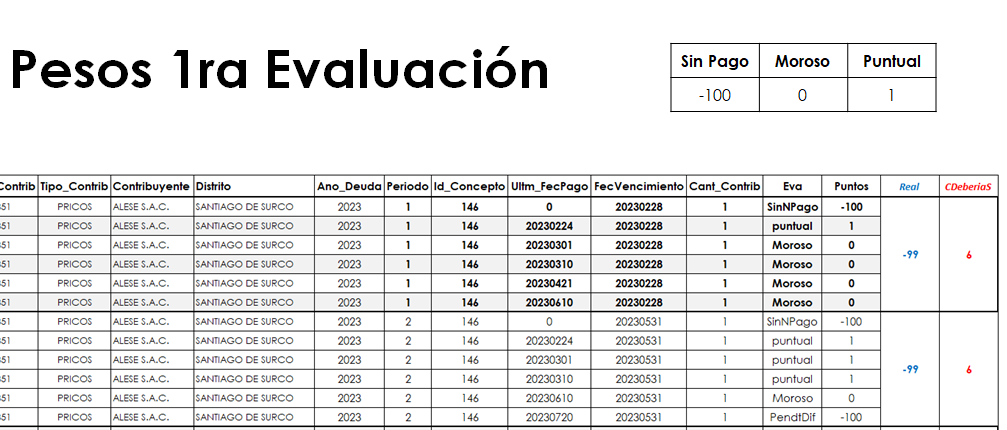

In [32]:
#Reduccion de tabla Perfil de Pago
df_PerfPagR = df_PerfilPago[['Cod_Contrib','Tipo_Contrib','Id_Concepto','Contribuyente','Periodo','Cant_Contrib','Llave','Evaluacion','Puntos','DetermPerPago','PesoPerPg']]
df_PerfPagR.sample(5)

,Cod_Contrib,Tipo_Contrib,Id_Concepto,Contribuyente,Periodo,Cant_Contrib,Llave,Evaluacion,Puntos,DetermPerPago,PesoPerPg
81455,234010,MEPECO,PREDIAL,VALVERDE ALVINAGORTA ISABEL,1,1,234010145,Sin_Pago,-100,5,1000
1000761,2687734,MEPECO,VEHICULAR,CORPORACION GNT S.A.C. - CORP GNT S.A.C.,2,1,2687734146,Sin_Pago,-100,5,1000
836981,2551615,MEPECO,VEHICULAR,ZAPATEL GARCIA CHRISTIAN ARNALDO,3,1,2551615146,Sin_Pago,-100,5,1000
854737,2567684,MEPECO,VEHICULAR,ARIAS SALAS YORDANIA,2,1,2567684146,Moroso,0,5,1000
718123,2460374,MEPECO,VEHICULAR,PALACIOS AUTOMATIC S.A.C.,1,1,2460374146,Puntual,1,1,0


In [33]:
# ARMANDO LA TABLA DE COMPARACION PUNTOS VS CANTIDAD

# Convertir columnas al tipo de Dato que le corresponden
df_PerfPagR['Periodo'] = df_PerfPagR['Periodo'].astype(str)
df_PerfPagR['Cant_Contrib'] = pd.to_numeric(df_PerfPagR['Cant_Contrib'])
df_PerfPagR['Puntos'] = pd.to_numeric(df_PerfPagR['Puntos'])
df_PerfPagR['PesoPerPg'] = pd.to_numeric(df_PerfPagR['PesoPerPg'])

# Agrupar por ['Cod_Contrib','Tipo_Contrib','Id_Concepto','Periodo']
# y luego sumar los 'Puntos' y adicional "Cant_Contri" en cada grupo
group1 = df_PerfPagR.groupby(['Cod_Contrib','Contribuyente','Tipo_Contrib','Id_Concepto','Periodo'])[['Puntos','Cant_Contrib','PesoPerPg']].sum()


# Pivoteando los datos para mostrar las sumas de la cantidad de contribuyentes por período
tb_pivotePerfP = group1.unstack().fillna(0).round(0)

tb_pivotePerfP.sample(12)

<ipython-input-33-9404e6e306ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PerfPagR['Periodo'] = df_PerfPagR['Periodo'].astype(str)
<ipython-input-33-9404e6e306ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PerfPagR['Cant_Contrib'] = pd.to_numeric(df_PerfPagR['Cant_Contrib'])
<ipython-input-33-9404e6e306ae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Puntos  \
Periodo                                                                        1   
Cod_Contrib Contribuyente                        Tipo_Contrib Id_Concepto          
2529312     TICONA GUTIERREZ LUZ LIZBETH         MEPECO       VEHICULAR   -100.0   
1878231     AQUINO LORENZO CATHERINE             MEPECO       VEHICULAR      1.0   
1874210     PRODUCTOS Y SERVICIOS SCOTT E.I.R.L. MEPECO       VEHICULAR      1.0   
1966447     MANTILLA AVILA KATHERINE PATRICIA    MEPECO       VEHICULAR      0.0   
91603       SKF DEL PERU S A                     PRICO        VEHICULAR      0.0   
229317      LOVON ALVAREZ RUBEN                  MEPECO       PREDIAL        1.0   
37048       FLORES ROSALES RAFAEL ANTONIO        MEPECO       PREDIAL     -100.0   
2581583     LOPEZ ERAZO ERICA PAOLA              MEPECO       VEHICULAR      0.0   
2639604     CALDERON PATIÑO AUGUSTO              MEPECO       PREDIAL        0.0   
2516614     HUAMAN FERNANDEZ MIGUEL FERNANDO     MEPECO       VEHICULAR      1.0   
2457865     VILLENA DE LA CRUZ DILAN CESAR       MEPECO       VEHICULAR      1.0   
2030213     GUIMA NAGAMINE MARCO ANTONIO         MEPECO       VEHICULAR      1.0   

                                                                                  \
Periodo                                                                        2   
Cod_Contrib Contribuyente                        Tipo_Contrib Id_Concepto          
2529312     TICONA GUTIERREZ LUZ LIZBETH         MEPECO       VEHICULAR   -100.0   
1878231     AQUINO LORENZO CATHERINE             MEPECO       VEHICULAR      1.0   
1874210     PRODUCTOS Y SERVICIOS SCOTT E.I.R.L. MEPECO       VEHICULAR      1.0   
1966447     MANTILLA AVILA KATHERINE PATRICIA    MEPECO       VEHICULAR      0.0   
91603       SKF DEL PERU S A                     PRICO        VEHICULAR      1.0   
229317      LOVON ALVAREZ RUBEN                  MEPECO       PREDIAL        1.0   
37048       FLORES ROSALES RAFAEL ANTONIO        MEPECO       PREDIAL        0.0   
2581583     LOPEZ ERAZO ERICA PAOLA              MEPECO       VEHICULAR      1.0   
2639604     CALDERON PATIÑO AUGUSTO              MEPECO       PREDIAL        0.0   
2516614     HUAMAN FERNANDEZ MIGUEL FERNANDO     MEPECO       VEHICULAR      1.0   
2457865     VILLENA DE LA CRUZ DILAN CESAR       MEPECO       VEHICULAR      1.0   
2030213     GUIMA NAGAMINE MARCO ANTONIO         MEPECO       VEHICULAR      1.0   

                                                                                  \
Periodo                                                                        3   
Cod_Contrib Contribuyente                        Tipo_Contrib Id_Concepto          
2529312     TICONA GUTIERREZ LUZ LIZBETH         MEPECO       VEHICULAR   -100.0   
1878231     AQUINO LORENZO CATHERINE             MEPECO       VEHICULAR   -100.0   
1874210     PRODUCTOS Y SERVICIOS SCOTT E.I.R.L. MEPECO       VEHICULAR      1.0   
1966447     MANTILLA AVILA KATHERINE PATRICIA    MEPECO       VEHICULAR   -100.0   
91603       SKF DEL PERU S A                     PRICO        VEHICULAR      1.0   
229317      LOVON ALVAREZ RUBEN                  MEPECO       PREDIAL     -100.0   
37048       FLORES ROSALES RAFAEL ANTONIO        MEPECO       PREDIAL        0.0   
2581583     LOPEZ ERAZO ERICA PAOLA              MEPECO       VEHICULAR      1.0   
2639604     CALDERON PATIÑO AUGUSTO              MEPECO       PREDIAL     -100.0   
2516614     HUAMAN FERNANDEZ MIGUEL FERNANDO     MEPECO       VEHICULAR   -100.0   
2457865     VILLENA DE LA CRUZ DILAN CESAR       MEPECO       VEHICULAR      1.0   
2030213     GUIMA NAGAMINE MARCO ANTONIO         MEPECO       VEHICULAR      1.0   

                                                                                  \
Periodo                                                                        4   
Cod_Contrib Contribuyente                        Tipo_Contrib Id_Concepto          
2529312     TICONA GUTIERREZ LUZ LIZBET

In [34]:
# Convertir los niveles de columnas en un índice de niveles múltiples
tb_pivotePerfP_stacked = tb_pivotePerfP.stack()

# Restaurar los niveles múltiples de índice como columnas
tb_pivotePerfP_flat = tb_pivotePerfP_stacked.reset_index()

#tb_pivotePerfP_flat.sample(5)

In [35]:
# Creacion de variables para determinar nuevo resultado
per = df_PerfPagR['Periodo']
pnt = df_PerfPagR['Puntos']
cant = df_PerfPagR['Cant_Contrib']
peso = df_PerfPagR['PesoPerPg']

# Creación nueva columna llamada "Evaluación"
df_PerfPagR['Result'] = 'r'

# Aplicar la lógica para determinar si es "Moroso", "Puntual" o "Sin Pago"
mask_perfPntl = ((pnt == cant) & (cant > 0))
df_PerfPagR.loc[mask_perfPntl, 'Result'] = 'p'

mask_perfMoroso = ((pnt < cant) & (pnt == 0))
df_PerfPagR.loc[mask_perfMoroso, 'Result'] = 'm'

mask_perfSinPago = ((cant*(-100) == pnt) & (cant > 0) & (pnt <= 0))
df_PerfPagR.loc[mask_perfSinPago, 'Result'] = '.'


df_PerfPagR

<ipython-input-35-96d460a6451e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PerfPagR['Result'] = 'r'


,Cod_Contrib,Tipo_Contrib,Id_Concepto,Contribuyente,Periodo,Cant_Contrib,Llave,Evaluacion,Puntos,DetermPerPago,PesoPerPg,Result
0,48,MEPECO,PREDIAL,AC ADEX CORP,1,1,48145,Sin_Pago,-100,5,1000,.
1,48,MEPECO,PREDIAL,AC ADEX CORP,2,1,48145,Sin_Pago,-100,5,1000,.
2,48,MEPECO,PREDIAL,AC ADEX CORP,3,1,48145,Sin_Pago,-100,5,1000,.
3,48,MEPECO,PREDIAL,AC ADEX CORP,4,1,48145,Sin_Pago,-100,5,1000,.
4,65,PRICO,PREDIAL,AGP INDUSTRIAS S A,1,1,65145,Puntual,1,1,0,p
...,...,...,...,...,...,...,...,...,...,...,...,...
1083766,2807788,MEPECO,VEHICULAR,CHINTE AGUIRRE LOUI GINO,4,1,2807788146,Puntual,1,3,10,p
1083767,2807794,MEPECO,VEHICULAR,ANCHANTE ORMEÑO CARLOS EDUARDO,1,1,2807794146,Moroso,0,5,1000,m
1083768,2807794,MEPECO,VEHICULAR,ANCHANTE ORMEÑO CARLOS EDUARDO,2,1,2807794146,Moroso,0,5,1000,m
1083769,2807794,MEPECO,VEHICULAR,ANCHANTE ORMEÑO CARLOS EDUARDO,3,1,2807794146,Puntual,1,3,10,p


In [36]:
# UNION DE RESULTADOS POR PERIODO POR CODIGO_CONTRIB
tb_resPerfPago= df_PerfPagR[['Cod_Contrib','Contribuyente','Tipo_Contrib','Id_Concepto','Puntos','Result','DetermPerPago','PesoPerPg']]
tb_resPerfPago= tb_resPerfPago.groupby(['Cod_Contrib','Contribuyente','Tipo_Contrib','Id_Concepto']).agg({'Result': 'sum', 'Puntos': 'sum', 'PesoPerPg': 'sum'}).reset_index() #Sumatoria por grupos

tb_resPerfPago

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,Result,Puntos,PesoPerPg
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,pppp,4,0
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,ppp.,-97,1012
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,pppp,4,0
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,pp..,-198,2002
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,....,-400,4000
...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,pppp,4,0
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,pppp,4,20
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,pp..,-198,2002
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,mmp.,-99,3010


In [37]:
# Creacion de variables para clasificar el resultado de cada periodo
res = tb_resPerfPago['Result']
peso = tb_resPerfPago['PesoPerPg']

# Creación nueva columna llamada "Evaluación"
tb_resPerfPago['rFinal'] = 'Observ.'

# Aplicar la lógica para determinar si es "Moroso", "Puntual" o "Sin Pago"
mask_rfPntl_Otr = ((res == 'mmmp') | (res == 'mmpp') | (res == 'ppmp') | (res == 'pmpp') | (res == 'mppp'))
tb_resPerfPago.loc[mask_rfPntl_Otr, 'rFinal'] = 'Puntual-Anual_Otros'

mask_rfPntlA1 = ((res == 'pppp') & (peso == 0))
tb_resPerfPago.loc[mask_rfPntlA1, 'rFinal'] = 'PA antes 28-02'

mask_rfPntlA2 = ((res == 'pppp') & (peso > 0) & (peso <= 6))
tb_resPerfPago.loc[mask_rfPntlA2, 'rFinal'] = 'PA antes 30-05'

mask_rfPntlA1 = ((res == 'pppp') & (peso > 9) & (peso <= 22))
tb_resPerfPago.loc[mask_rfPntlA1, 'rFinal'] = 'PA antes 31-08'

mask_rfPntlA1 = ((res == 'pppp') & (peso >= 1000))
tb_resPerfPago.loc[mask_rfPntlA1, 'rFinal'] = 'PA antes 30-11'


mask_rfPc123a = ((res == 'ppp.'))
tb_resPerfPago.loc[mask_rfPc123a, 'rFinal'] = 'Puntual-Trim_123'
mask_rfPc123b = ((res == 'mmp.') | (res == 'pmm.') | (res == 'mpp.') | (res == 'ppm.'))
tb_resPerfPago.loc[mask_rfPc123b, 'rFinal'] = 'AlDia-Trim_123'

mask_rfPc12a = ((res == 'pp..'))
tb_resPerfPago.loc[mask_rfPc12a, 'rFinal'] = 'Puntual-Trim_12'
mask_rfPc12b = ((res == 'mp..') | (res == 'pm..') | (res == 'mm..'))
tb_resPerfPago.loc[mask_rfPc12b, 'rFinal'] = 'AlDia-Trim_12'

mask_rfPntlc1 = (res == 'p...')
tb_resPerfPago.loc[mask_rfPntlc1, 'rFinal'] = 'Puntual-Trim_1'

mask_rfMorl = (res == 'm...')
tb_resPerfPago.loc[mask_rfMorl, 'rFinal'] = 'Moroso-Trim_1'

mask_rfSinP = (res == '....')
tb_resPerfPago.loc[mask_rfSinP, 'rFinal'] = 'Sin-Pago'


tb_resPerfPago

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,Result,Puntos,PesoPerPg,rFinal
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,pppp,4,0,PA antes 28-02
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,ppp.,-97,1012,Puntual-Trim_123
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,pppp,4,0,PA antes 28-02
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,pp..,-198,2002,Puntual-Trim_12
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,....,-400,4000,Sin-Pago
...,...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,pppp,4,0,PA antes 28-02
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,pppp,4,20,PA antes 31-08
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,pp..,-198,2002,Puntual-Trim_12
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,mmp.,-99,3010,AlDia-Trim_123


## **AGREGANDO SALDOS ACTUALIZADOS**
(Al día anterior)





### FILTRANDO SALDOS POR CUOTAS U OTRO CRITERIO

In [38]:
#OBTENIENDO EL SALDO DE LAS CUOTAS 1-2

df_SaldoC12 = df_ConsolMasivaComp[['Cod_Contrib','Id_Concepto','Periodo','Pendiente']]
df_SaldoC12['Pendiente'] = pd.to_numeric(df_ConsolMasivaComp['Pendiente'])

#FILTRANDO POR SOLO CUENTA CORRIENTE Y CUOTA 1-2
df_SaldoC12 = df_SaldoC12[(df_SaldoC12.Periodo.isin(['1','2']))]
df_SaldoC12 = df_SaldoC12.rename(columns={'Pendiente':'sCuota_12'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

tb_SaldoC12 = df_SaldoC12.groupby(['Cod_Contrib','Id_Concepto'])['sCuota_12'].sum().reset_index()
tb_SaldoC12['Llave']= tb_SaldoC12['Cod_Contrib'] + tb_SaldoC12['Id_Concepto'] #Agregando Llave

tb_SaldoC12

<ipython-input-38-13e270371c91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SaldoC12['Pendiente'] = pd.to_numeric(df_ConsolMasivaComp['Pendiente'])


,Cod_Contrib,Id_Concepto,sCuota_12,Llave
0,1000005,VEHICULAR,0.0,1000005VEHICULAR
1,1000016,VEHICULAR,0.0,1000016VEHICULAR
2,1000021,PREDIAL,0.0,1000021PREDIAL
3,100003,PREDIAL,0.0,100003PREDIAL
4,1000035,PREDIAL,18.0,1000035PREDIAL
...,...,...,...,...
274568,999950,PREDIAL,0.0,999950PREDIAL
274569,999950,VEHICULAR,0.0,999950VEHICULAR
274570,999985,VEHICULAR,0.0,999985VEHICULAR
274571,999988,PREDIAL,0.0,999988PREDIAL


In [39]:
#OBTENIENDO EL SALDO DE LAS CUOTAS 3

df_SaldoC3 = df_ConsolMasivaComp[['Cod_Contrib','Id_Concepto','Periodo','Pendiente']]
df_SaldoC12['Pendiente'] = pd.to_numeric(df_ConsolMasivaComp['Pendiente'])

#FILTRANDO POR SOLO CUENTA CORRIENTE Y CUOTA 3
df_SaldoC3 = df_SaldoC3[(df_SaldoC3.Periodo.isin(['3']))]
df_SaldoC3 = df_SaldoC3.rename(columns={'Pendiente':'sCuota_3'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

tb_SaldoC3 = df_SaldoC3.groupby(['Cod_Contrib','Id_Concepto'])['sCuota_3'].sum().reset_index()
tb_SaldoC3['Llave']= tb_SaldoC3['Cod_Contrib'] + tb_SaldoC3['Id_Concepto'] #Agregando Llave

#tb_SaldoC3

In [40]:
#OBTENIENDO EL SALDO DE LAS CUOTAS 4

df_SaldoC4 = df_ConsolMasivaComp[['Cod_Contrib','Id_Concepto','Periodo','Pendiente']]
df_SaldoC12['Pendiente'] = pd.to_numeric(df_ConsolMasivaComp['Pendiente'])

#FILTRANDO POR SOLO CUENTA CORRIENTE Y CUOTA 4
df_SaldoC4 = df_SaldoC4[(df_SaldoC4.Periodo.isin(['4']))]
df_SaldoC4 = df_SaldoC4.rename(columns={'Pendiente':'sCuota_4'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

tb_SaldoC4 = df_SaldoC4.groupby(['Cod_Contrib','Id_Concepto'])['sCuota_4'].sum().reset_index()
tb_SaldoC4['Llave']= tb_SaldoC4['Cod_Contrib'] + tb_SaldoC4['Id_Concepto'] #Agregando Llave
df_SaldoC4 = df_SaldoC4.rename(columns={'Pendiente':'sCuota_4'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

#tb_SaldoC4

In [41]:
#df_sCoactiva_cc22.sample(5)

In [42]:
#OBTENIENDO EL SALDO DE LAS CUOTAS COACTIVA CC-2022

df_sCoact_cc22 = df_sCoactiva_cc22[['Cod_Contrib','ID_Concepto','Año_Deuda','Grupo Etapa Cobranza','Deuda_Insol']]
df_sCoact_cc22['Deuda_Insol'] = pd.to_numeric(df_sCoact_cc22['Deuda_Insol'].str.replace(',', ''), errors='coerce')
df_sCoact_cc22 = df_sCoact_cc22.rename(columns={'ID_Concepto':'Id_Concepto'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

df_sCoact_cc22['Id_Concepto'] = df_sCoact_cc22['Id_Concepto'].astype(str)
df_sCoact_cc22['Cod_Contrib'] = df_sCoact_cc22['Cod_Contrib'].astype(str)
df_sCoact_cc22['Id_Concepto'] = df_sCoact_cc22['Id_Concepto'].str.upper()
df_sCoact_cc22['Cod_Contrib'] = df_sCoact_cc22['Cod_Contrib'].astype(str).str.split('.').str[0]
df_sCoact_cc22['Id_Concepto'] = df_sCoact_cc22['Id_Concepto'].replace({'145.0':'PREDIAL','146.0':'VEHICULAR','200.0':'ARBITRIOS'}) #Cambiar registro

#FILTRANDO POR SOLO CUENTA CORRIENTE Y DEUDA 2022
tb_sCoact_cc= df_sCoact_cc22
tb_sCoact_22= df_sCoact_cc22

tb_sCoact_cc = tb_sCoact_cc[(tb_sCoact_cc['Grupo Etapa Cobranza'].isin(['Coactivo'])) & (tb_sCoact_cc['Año_Deuda'].isin([2023]))]
tb_sCoact_22 = tb_sCoact_22[(tb_sCoact_22['Grupo Etapa Cobranza'].isin(['Coactivo'])) & (tb_sCoact_22['Año_Deuda'].isin([2022]))]

tb_sCoact_cc = tb_sCoact_cc.rename(columns={'Deuda_Insol':'sCoact_CC'}) #CAMBIO NUEVO NOMBRE DE COLUMNA
tb_sCoact_22 = tb_sCoact_22.rename(columns={'Deuda_Insol':'sCoact_22'}) #CAMBIO NUEVO NOMBRE DE COLUMNA

tb_sCoact_cc = tb_sCoact_cc.groupby(['Cod_Contrib','Id_Concepto'])['sCoact_CC'].sum().reset_index()
tb_sCoact_22 = tb_sCoact_22.groupby(['Cod_Contrib','Id_Concepto'])['sCoact_22'].sum().reset_index()

tb_sCoact_cc['Llave']= tb_sCoact_cc['Cod_Contrib'] + tb_sCoact_cc['Id_Concepto'] #Agregando Llave
tb_sCoact_22['Llave']= tb_sCoact_22['Cod_Contrib'] + tb_sCoact_22['Id_Concepto'] #Agregando Llave

tb_sCoact_22

<ipython-input-42-b0a9af5533db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sCoact_cc22['Deuda_Insol'] = pd.to_numeric(df_sCoact_cc22['Deuda_Insol'].str.replace(',', ''), errors='coerce')


,Cod_Contrib,Id_Concepto,sCoact_22,Llave
0,100006,ARBITRIOS,88.08,100006ARBITRIOS
1,100032,ARBITRIOS,59.04,100032ARBITRIOS
2,1000392,ARBITRIOS,253.08,1000392ARBITRIOS
3,100042,ARBITRIOS,100.26,100042ARBITRIOS
4,100042,PREDIAL,103.79,100042PREDIAL
...,...,...,...,...
46397,999657,ARBITRIOS,303.96,999657ARBITRIOS
46398,999657,PREDIAL,58.80,999657PREDIAL
46399,999661,ARBITRIOS,193.92,999661ARBITRIOS
46400,99967,ARBITRIOS,187.20,99967ARBITRIOS


### AGREGANDO LOS SALDOS SEGUN CRITERIO

In [43]:
tb_resPerfPago.sample(1)

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,Result,Puntos,PesoPerPg,rFinal
227761,29720,DIAZ CRUZ ALBERTO,MEPECO,PREDIAL,....,-400,4000,Sin-Pago


In [44]:
tb_SaldoC12.sample(1)

,Cod_Contrib,Id_Concepto,sCuota_12,Llave
94212,2170270,PREDIAL,0.0,2170270PREDIAL


In [45]:
tb_sCoact_cc.sample(1)

,Cod_Contrib,Id_Concepto,sCoact_CC,Llave
10647,158692,PREDIAL,186.78,158692PREDIAL


In [46]:
tb_sCoact_22.sample(1)

,Cod_Contrib,Id_Concepto,sCoact_22,Llave
21222,2335782,VEHICULAR,381.6,2335782VEHICULAR


In [47]:
tb_fPerfP_Saldos = tb_resPerfPago

#Creando una llave para cruzar saldos
tb_fPerfP_Saldos['Llave'] = tb_fPerfP_Saldos['Cod_Contrib'] + tb_fPerfP_Saldos['Id_Concepto']

#CRUCE O UNION DE SALDOS EN LA DATA MASIVA
tb_fPerfP_Saldos = pd.merge(tb_resPerfPago, tb_SaldoC12, how='left').merge(tb_SaldoC3, how='left').merge(tb_SaldoC4, how='left').merge(tb_sCoact_cc, how='left').merge(tb_sCoact_22, how='left')

# Llenar los valores nulos resultantes con 0
tb_fPerfP_Saldos.fillna(0, inplace=True)

tb_fPerfP_Saldos= tb_fPerfP_Saldos[['Cod_Contrib','Contribuyente','Tipo_Contrib','Id_Concepto','Result','rFinal','sCuota_12','sCuota_3','sCuota_4','sCoact_CC','sCoact_22']]

#tb_fPerfP_Saldos

## **CRUCE CON CARTILLAS NOTIFICADAS - CORTE MAR-2023**

**DATA GENERAL MASIVA CUENTA CORRIENTE**

In [52]:
# UNION BASE DE NOTIFICACIONES PAV
cartNotifP= df_CartNotif_AP[['Codigo','Distrito','Zona','EstadoNotif','Motivo de Notificación']]
cartNotifA= df_CartNotif_AP[['Codigo','Distrito','Zona','Motivo de Notificación']]
cartNotifA['Codigo']= cartNotifA['Codigo'].astype(str)
cartNotifP['Codigo']= cartNotifP['Codigo'].astype(str)
cartNotifP['Llave']= cartNotifP['Codigo'] + 'PREDIAL'
cartNotifA['Llave']= cartNotifA['Codigo'] + 'ARBITRIOS'

cartNotifV= df_CartNotif_V[['Codigo','Distrito','Zona','EstadoNotif','Motivo de Notificación']]
cartNotifV['Codigo']= cartNotifV['Codigo'].astype(str)
cartNotifV['Llave']= cartNotifV['Codigo'] + 'VEHICULAR'

cartillasNotif = pd.concat([cartNotifP, cartNotifA, cartNotifV], axis=0).reset_index()

#cartillasNotif

<ipython-input-52-3467f5fc7a42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cartNotifA['Codigo']= cartNotifA['Codigo'].astype(str)
<ipython-input-52-3467f5fc7a42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cartNotifP['Codigo']= cartNotifP['Codigo'].astype(str)
<ipython-input-52-3467f5fc7a42>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [53]:
#REDUCIR BASE CARTILLAS NOTIF A SOLO ['COD_CONTRIB' Y 'ESTADO NOTIFICACION']
bcartNotif= cartillasNotif[['Llave','EstadoNotif','Motivo de Notificación']]
bcartNotif

,Llave,EstadoNotif,Motivo de Notificación
0,2219697PREDIAL,Notificado,Se negó a recibir
1,2631964PREDIAL,Notificado,Domicilio cerrado
2,842961PREDIAL,Notificado,Se negó a recibir
3,93656PREDIAL,Notificado,Notificado
4,758338PREDIAL,Notificado,Se negó a recibir
...,...,...,...
369739,1812183VEHICULAR,No Notificado,Dirección no existe
369740,1949523VEHICULAR,Notificado,Se negó a recibir
369741,1866685VEHICULAR,Notificado,Notificado
369742,2721424VEHICULAR,Notificado,Se negó a recibir


In [54]:
# CREANDO LLAVE A LA BASE FINAL DE MASIVA
tb_fPerfP_Saldos['Llave']= tb_fPerfP_Saldos['Cod_Contrib'] + tb_fPerfP_Saldos['Id_Concepto']

In [55]:
DataG= pd.merge(tb_fPerfP_Saldos, bcartNotif, how='left')
DataG= DataG[['Cod_Contrib',	'Contribuyente',	'Tipo_Contrib',	'Id_Concepto', 'rFinal',	'sCuota_12',	'sCuota_3',	'sCuota_4',	'sCoact_CC',	'sCoact_22', 'EstadoNotif'	,'Motivo de Notificación']]
DataG= DataG.rename(columns={'Motivo de Notificación':'NotifCartll'}).astype(str)
# Llenar los valores nulos resultantes con 0
DataG.fillna(0, inplace=True)
DataG

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22,EstadoNotif,NotifCartll
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Se negó a recibir
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,Puntual-Trim_123,0.0,0.0,189.9,0.0,0.0,Notificado,Notificado
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,Puntual-Trim_12,0.0,48.27,48.27,0.0,0.0,Notificado,Notificado
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,Sin-Pago,18.0,9.0,9.0,0.0,0.0,Notificado,Domicilio cerrado
...,...,...,...,...,...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,PA antes 31-08,0.0,0.0,0.0,0.0,0.0,Notificado,Notificado
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,Puntual-Trim_12,0.0,120.5,120.5,0.0,0.0,Notificado,Se negó a recibir
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,AlDia-Trim_123,0.0,0.0,34.68,0.0,0.0,Notificado,Domicilio cerrado


## **CRUCE PARA COACTIVA DATA PAGO USO TARJETA (2018-2023)**

In [56]:
# DATA FILTRADA POR: ('Moroso-C1','Puntual-C1','Puntual-C12')
DataG['sCoact_CC']= pd.to_numeric(DataG['sCoact_CC'])
# Coact_cc = DataG[(DataG['sCoact_CC']>0) & (DataG['rFinal']).isin(['Moroso-C1','Puntual-C1','Puntual-C12'])]
DataG

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22,EstadoNotif,NotifCartll
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Se negó a recibir
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,Puntual-Trim_123,0.0,0.0,189.9,0.0,0.0,Notificado,Notificado
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,Puntual-Trim_12,0.0,48.27,48.27,0.0,0.0,Notificado,Notificado
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,Sin-Pago,18.0,9.0,9.0,0.0,0.0,Notificado,Domicilio cerrado
...,...,...,...,...,...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,PA antes 31-08,0.0,0.0,0.0,0.0,0.0,Notificado,Notificado
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,Puntual-Trim_12,0.0,120.5,120.5,0.0,0.0,Notificado,Se negó a recibir
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,AlDia-Trim_123,0.0,0.0,34.68,0.0,0.0,Notificado,Domicilio cerrado


In [57]:
# CRUCE CON DATA PAGO CON TARJETA
tbPagoT = df_pagoTarjeta[['Etiquetas de fila','Tarjetas']]
tbPagoT = tbPagoT.rename(columns={'Etiquetas de fila':'Cod_Contrib'})
tbPagoT['Cod_Contrib'] = tbPagoT['Cod_Contrib'].astype(str)

DataG = pd.merge(DataG, tbPagoT, how='left')
DataG.fillna('.', inplace=True)

DataG

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22,EstadoNotif,NotifCartll,Tarjetas
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Se negó a recibir,.
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,Puntual-Trim_123,0.0,0.0,189.9,0.0,0.0,Notificado,Notificado,.
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado,Visa Electron-Nacional
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,Puntual-Trim_12,0.0,48.27,48.27,0.0,0.0,Notificado,Notificado,Pago Virtual
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,Sin-Pago,18.0,9.0,9.0,0.0,0.0,Notificado,Domicilio cerrado,Visa Electron-Nacional
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Notificado,Domicilio cerrado,"Visa Electron-Nacional, Visa Nacional, Masterc..."
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,PA antes 31-08,0.0,0.0,0.0,0.0,0.0,Notificado,Notificado,"Visa Electron-Nacional, Visa Nacional, Masterc..."
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,Puntual-Trim_12,0.0,120.5,120.5,0.0,0.0,Notificado,Se negó a recibir,Pago Virtual
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,AlDia-Trim_123,0.0,0.0,34.68,0.0,0.0,Notificado,Domicilio cerrado,.


In [58]:
df_pagoTarjeta

,Etiquetas de fila,Tarjetas
0,4,"Visa Electron-Nacional, Visa Nacional, Pago Vi..."
1,54,Pago Virtual
2,70,Pago Virtual
3,82,Pago Virtual
4,122,Pago Virtual
...,...,...
303316,2801631,Visa Electron-Nacional
303317,2801638,Visa Electron-Nacional
303318,2802000,Visa Electron-Nacional
303319,2802014,Visa Nacional


In [59]:
#x['Tipo Pago'].unique()

## **CRUCE CON DOMICILIO FISCAL**

In [60]:
df_domFiscal['Cod_Contrib']= df_domFiscal['Cod_Contrib'].astype(str)
DataFinal = DataG
DataFinal= pd.merge(DataG, df_domFiscal, how='left')
# Llenar los valores nulos resultantes con 0
DataFinal.fillna(0, inplace=True)
DataFinal= DataFinal[['Cod_Contrib',	'Contribuyente',	'Tipo_Contrib',	'Id_Concepto', 'DistritoDomF', 'DomicilioFis', 'EstadoNotif'	,'NotifCartll', 'rFinal',	'sCuota_12',	'sCuota_3',	'sCuota_4',	'sCoact_CC',	'sCoact_22', 'Tarjetas']]
DataFinal= DataFinal.rename(columns={'rFinal':'PerfilPago'}).astype(str)
DataFinal['DistritoDomF']= DataFinal['DistritoDomF'].replace({'0':'-'}) #Cambio de registro por otro
DataFinal['DomicilioFis']= DataFinal['DomicilioFis'].replace({'0':'-'}) #Cambio de registro por otro
DataFinal

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,DistritoDomF,DomicilioFis,EstadoNotif,NotifCartll,PerfilPago,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22,Tarjetas
0,1000005,OLGUIN NEIRA CARLA MARIA,MEPECO,VEHICULAR,-,-,Notificado,Se negó a recibir,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,.
1,1000016,GARCIA DELGADO MARIA DELPILAR SELFA ENRIQUETA,MEPECO,VEHICULAR,-,-,Notificado,Notificado,Puntual-Trim_123,0.0,0.0,189.9,0.0,0.0,.
2,1000021,LIRA VASQUEZ CHRISTYAN FERNANDO,MEPECO,PREDIAL,LIMA,"CL CARLOS RODRIGO 1044, LIMA",Notificado,Domicilio cerrado,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,Visa Electron-Nacional
3,100003,VALDIVIA AGUAYO VICTORIA RITA,MEPECO,PREDIAL,LIMA,"PLZ MESA REDONDA 988 Dpto 207 Piso 2, LIMA",Notificado,Notificado,Puntual-Trim_12,0.0,48.27,48.27,0.0,0.0,Pago Virtual
4,1000035,SAAVEDRA ALIAGA PERSA JULIANA,MEPECO,PREDIAL,JESUS MARIA,"AV REPUBLICA DOMINICANA 238 Dpto 4, JESUS MARIA",Notificado,Domicilio cerrado,Sin-Pago,18.0,9.0,9.0,0.0,0.0,Visa Electron-Nacional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274568,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,PREDIAL,SAN MARTIN DE PORRES,"JR. LAS ENCINAS 533 URB. LOS JARDINES, SAN MAR...",Notificado,Domicilio cerrado,PA antes 28-02,0.0,0.0,0.0,0.0,0.0,"Visa Electron-Nacional, Visa Nacional, Masterc..."
274569,999950,ARANA VASQUEZ JORGE MIGUEL,MEPECO,VEHICULAR,SAN MARTIN DE PORRES,"JR. LAS ENCINAS 533 URB. LOS JARDINES, SAN MAR...",Notificado,Notificado,PA antes 31-08,0.0,0.0,0.0,0.0,0.0,"Visa Electron-Nacional, Visa Nacional, Masterc..."
274570,999985,SARRIA PARDO VIRGINIA PATRICIA,MEPECO,VEHICULAR,-,-,Notificado,Se negó a recibir,Puntual-Trim_12,0.0,120.5,120.5,0.0,0.0,Pago Virtual
274571,999988,VIGO SALCEDO VILMA HORTENCIA,MEPECO,PREDIAL,LIMA,"JR JOSE FELIX BOGADO 2518 Dpto 401, LIMA",Notificado,Domicilio cerrado,AlDia-Trim_123,0.0,0.0,34.68,0.0,0.0,.


In [61]:
#Exportar en archivo Excel
DataFinal.to_excel('SeguimientoMasiva_CuentaCorriente.xlsx',encoding='latin1')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


## **PERFIL SOLO PUNTUALES ANUALES**
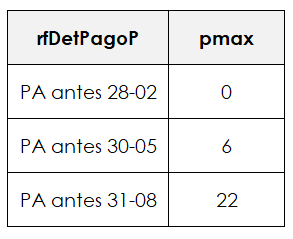

## **RESUMEN OTROS**

In [ ]:
##FILTROS POR TIPO CONTRIB

rf_Masiva = DataG
prico = rf_Masiva[rf_Masiva['Tipo_Contrib'].isin(['PRICO'])]
prico

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22,EstadoNotif,NotifCartll
181,1001392,PACHACAYO SAC,PRICO,VEHICULAR,Observ.,0.0,0.0,5403.47,0.0,0.0,Notificado,Notificado
203,1001567,HUAMAN ANAYA JENNY,PRICO,PREDIAL,Puntual-C12,0.0,3049.84,3049.84,0.0,0.0,Notificado,Domicilio cerrado
229,1001799,INVERSIONES HELU S.A.C.,PRICO,VEHICULAR,Puntual-C1,3404.37,3404.37,3404.37,3404.37,0.0,Notificado,Domicilio cerrado
238,1001920,CORPORACION KAPIA SOCIEDAD ANONIMA,PRICO,PREDIAL,Sin-Pago,57.6,28.8,28.8,57.6,106.84,Notificado,Domicilio cerrado
261,1002196,MARVANNSS LOGISTIC SAC,PRICO,VEHICULAR,Puntual-C12,0.0,8254.85,8254.85,0.0,0.0,Notificado,Se negó a recibir
...,...,...,...,...,...,...,...,...,...,...,...,...
274528,99961,VALDEZ PINO AGUSTIN ANTONIO,PRICO,PREDIAL,Sin-Pago,266.06,133.03,133.03,266.06,496.48,Notificado,Domicilio cerrado
274542,999685,INDUSTRIAS ROLAND PRINT SAC,PRICO,PREDIAL,Puntual-C123,0.0,0.0,4102.31,0.0,0.0,Notificado,Notificado
274543,999685,INDUSTRIAS ROLAND PRINT SAC,PRICO,VEHICULAR,Puntual-C12,0.0,399.29,399.29,0.0,0.0,Notificado,Notificado
274548,999747,SERVICIO DE LOGISTICA EXPRESS SOCIEDAD ANONIMA...,PRICO,VEHICULAR,Puntual-Anual,0.0,0.0,0.0,0.0,0.0,Notificado,Notificado


In [ ]:
##RESUMEN DE SALDO POR CONCEPTO Y PERFIL DE PAGO

prico['sCuota_12'] = pd.to_numeric(prico['sCuota_12'])
prico['sCuota_3'] = pd.to_numeric(prico['sCuota_3'])
prico['sCuota_4'] = pd.to_numeric(prico['sCuota_4'])
prico['sCoact_CC'] = pd.to_numeric(prico['sCoact_CC'])
prico['sCoact_22'] = pd.to_numeric(prico['sCoact_22'])

tb_saldoConcepPrico = prico.groupby(['Id_Concepto','rFinal'])[['sCuota_12','sCuota_3','sCuota_4','sCoact_CC','sCoact_22']].sum().reset_index()
#df_Pagos['Recaudado']= round(pd.to_numeric(df_Pagos['Recaudado'].str.replace(',', ''), errors='coerce'),0)



# Formatear las columnas que contienen decimales
tb_saldoConcepPrico[['sCuota_12','sCuota_3','sCuota_4','sCoact_CC','sCoact_22']] = tb_saldoConcepPrico[['sCuota_12','sCuota_3','sCuota_4','sCoact_CC','sCoact_22']].applymap('{:,.2f}'.format)

tb_saldoConcepPrico

<ipython-input-65-fdff077729bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prico['sCuota_12'] = pd.to_numeric(prico['sCuota_12'])
<ipython-input-65-fdff077729bb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prico['sCuota_3'] = pd.to_numeric(prico['sCuota_3'])
<ipython-input-65-fdff077729bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22
0,PREDIAL,Moroso-C1,"185,945.80","185,945.80","185,945.80","176,699.50","39,413.72"
1,PREDIAL,Observ.,"807,668.41","661,068.00","918,148.02","451,289.80","415,632.82"
2,PREDIAL,Puntual-Anual,0.00,0.00,0.00,0.00,"38,372.37"
3,PREDIAL,Puntual-C1,"46,568.01","46,568.01","46,568.01","42,689.46","56,379.39"
4,PREDIAL,Puntual-C12,0.00,"5,174,811.89","5,210,575.30",0.00,"118,581.72"
5,PREDIAL,Puntual-C123,0.00,0.00,"1,308,359.56",0.00,"24,493.36"
6,PREDIAL,Sin-Pago,"3,355,291.00","1,682,104.66","1,682,104.66","2,594,648.65","3,816,047.17"
7,VEHICULAR,Moroso-C1,"162,998.18","162,998.18","162,998.18","95,117.30","29,373.26"
8,VEHICULAR,Observ.,"827,991.97","6,221,055.70","6,937,021.87","445,578.72","360,416.94"
9,VEHICULAR,Puntual-Anual,0.00,0.00,0.00,0.00,"13,170.21"


In [ ]:
#Resumen Puntuales con Coactiva - Deuda 2022
puntualCoact = tb_saldoConcepPrico[tb_saldoConcepPrico['rFinal'].isin(['Puntual-Anual'])]
puntualCoact

,Id_Concepto,rFinal,sCuota_12,sCuota_3,sCuota_4,sCoact_CC,sCoact_22
2,PREDIAL,Puntual-Anual,0.00,0.00,0.00,0.00,"38,372.37"
9,VEHICULAR,Puntual-Anual,0.00,0.00,0.00,0.00,"13,170.21"


In [ ]:
#Relacion de Puntuales con Coactiva - Deuda 2022

tb_resPerfPago #tabla resultado final Perfil de Pago
puntualCoact22 = tb_resPerfPago[(tb_resPerfPago['rFinal'].isin(['Puntual-Anual'])) & (prico['sCoact_22'] > 0)]
puntualCoact22.sample(5)

,Cod_Contrib,Contribuyente,Tipo_Contrib,Id_Concepto,Result,rFinal,Llave
90472,2119841,TABOADA ESPINOZA ANA (SUC INDIVISA),PRICO,PREDIAL,mppp,Puntual-Anual,2119841PREDIAL
245527,703533,BARRENECHEA CALDERON JULIO CESAR,PRICO,PREDIAL,pppp,Puntual-Anual,703533PREDIAL
198149,26768,CHIRINOS MALDONADO ALFREDO SANTOS BRUNO,PRICO,PREDIAL,pppp,Puntual-Anual,26768PREDIAL
268404,940434,GARCIA SALVATIERRA NAZARIO (SUC INDIVISA),PRICO,PREDIAL,mppp,Puntual-Anual,940434PREDIAL
263339,899771,PEREZ ESTEBAN MAURICIA YOLI,PRICO,PREDIAL,mppp,Puntual-Anual,899771PREDIAL


In [ ]:
#Exportar en archivo Excel
puntualCoact.to_excel('Puntuales_Coact_2022.xlsx',encoding='latin1')

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


## *LIMPIEZA DATA*


DATA SALDO GENERAL

In [ ]:
df_saldoG['Deuda_Insol'].dtype
#eliminacion de filas nulas
df_saldoG= df_saldoG.dropna()
df_saldoG['Tipo Contribuyente']= df_saldoG['Tipo Contribuyente'].replace({'Grande':'PRICO','Mediano':'MEPECO','Pequeño':'MEPECO'}) #TipContri
df_saldoG['ID_Concepto']= df_saldoG['ID_Concepto'].replace({145.0:'PREDIAL',146.0:'VEHICULAR',200.0:'ARBITRIOS'}) #Concepto
df_saldoG['Cod_Contrib']= df_saldoG['Cod_Contrib'].astype(str) #CodigoContrib a String

df_saldoG

<ipython-input-5-0bc915fd788e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saldoG['Tipo Contribuyente']= df_saldoG['Tipo Contribuyente'].replace({'Grande':'PRICO','Mediano':'MEPECO','Pequeño':'MEPECO'}) #TipContri
<ipython-input-5-0bc915fd788e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_saldoG['ID_Concepto']= df_saldoG['ID_Concepto'].replace({145.0:'PREDIAL',146.0:'VEHICULAR',200.0:'ARBITRIOS'}) #Concepto
<ipython-input-5-0bc915fd788e>:6: SettingWithCopyWarning: 
A value is trying to be set

,Cod_Contrib,Contribuyente,Tipo Contribuyente,Grupo_AñDeuda,Año_Deuda,ID_Concepto,Distrito,Deuda_Total,Deuda_Insol
0,1133396.0,PACCO VARGAS CIPRIANO,MEPECO,2017-AA,2004.0,Predial,LIMA,159.41,19.2
1,1133396.0,PACCO VARGAS CIPRIANO,MEPECO,2017-AA,2005.0,Predial,LIMA,108.17,19.8
2,1133396.0,PACCO VARGAS CIPRIANO,MEPECO,2017-AA,2006.0,Predial,LIMA,132.08,20.4
3,1133396.0,PACCO VARGAS CIPRIANO,MEPECO,2017-AA,2007.0,Predial,LIMA,130.5,20.72
4,1133396.0,PACCO VARGAS CIPRIANO,MEPECO,2017-AA,2008.0,Arbitrios,LIMA,708.59,207.36
...,...,...,...,...,...,...,...,...,...
586087,2799107.0,PACHECO CAYCHO ERIKA BEATRIZ,MEPECO,2023.0,2023.0,Predial,LIMA,15.34,14.86
586088,2799240.0,BAUTISTA PADILLA ANA EMILIA,MEPECO,2023.0,2023.0,Arbitrios,LIMA,2.45,1.2
586089,2799240.0,BAUTISTA PADILLA ANA EMILIA,MEPECO,2023.0,2023.0,Predial,LIMA,17.14,14.86
586090,2799106.0,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,2023.0,2023.0,Arbitrios,SAN JUAN DE LURIGANCHO,16.99,15.3


SALDO DE CUOTAS NO VENCIDAS

In [ ]:
df_sCuotasNV.sample(5)

,Cod_Contrib,Contribuyente,Tipo Contribuyente,Distrito,Año_Deuda,Periodo_Deuda,Grupo Etapa Cobranza,ID_Concepto,Con_Exclusion,Deuda_Total,Deuda_Insol
331340,2522697,MUÑOZ ESTUPIÑAN MARIA MELISSA,MEPECO,SAN MARTIN DE PORRES,2023,4,Preventivo,146,NO,106.2,106.2
230008,1948204,MAMANI LEON ROBERTO,MEPECO,SANTIAGO DE SURCO,2023,4,Preventivo,146,NO,179.66,179.66
379911,2618326,ABARCA GUTIERREZ WALTER JESUS,MEPECO,SAN MARTIN DE PORRES,2023,4,Preventivo,146,NO,99.9,99.9
269396,2259218,HIRAKAWA SHIKIYA LUIS ENRIQUE,MEPECO,LIMA,2023,4,Preventivo,145,NO,9.49,9.49
446692,2789758,JUAREZ REQUE JOSEPH ARIEL,MEPECO,SAN BORJA,2023,3,Preventivo,146,NO,174.2,174.2


In [ ]:
#eliminacion de filas nulas
df_sCuotasNV= df_sCuotasNV.dropna()
df_sCuotasNV['Tipo Contribuyente']= df_sCuotasNV['Tipo Contribuyente'].replace({'Grande':'PRICO','Mediano':'MEPECO','Pequeño':'MEPECO'}) #TipContri
df_sCuotasNV['ID_Concepto']= df_sCuotasNV['ID_Concepto'].replace({145:'PREDIAL',146:'VEHICULAR',200:'ARBITRIOS'}) #Concepto
df_sCuotasNV['Cod_Contrib']= df_sCuotasNV['Cod_Contrib'].astype(str) #CodigoContrib a String

df_sCuotasNV

,Cod_Contrib,Contribuyente,Tipo Contribuyente,Distrito,Año_Deuda,Periodo_Deuda,Grupo Etapa Cobranza,ID_Concepto,Con_Exclusion,Deuda_Total,Deuda_Insol
0,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2023,4,Preventivo,ARBITRIOS,NO,76.32,76.32
1,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2023,4,Preventivo,PREDIAL,NO,7.43,7.43
2,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2023,3,Preventivo,ARBITRIOS,NO,76.32,76.32
3,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2023,3,Preventivo,PREDIAL,NO,7.43,7.43
4,1288124,RIVERA CAMAQUI BETTY SIMONA,MEPECO,LIMA,2023,4,Preventivo,ARBITRIOS,NO,134.25,134.25
...,...,...,...,...,...,...,...,...,...,...,...
448408,2799240,BAUTISTA PADILLA ANA EMILIA,MEPECO,LIMA,2023,3,Preventivo,PREDIAL,-,7.43,7.43
448409,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,4,Preventivo,ARBITRIOS,-,7.65,7.65
448410,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,4,Preventivo,PREDIAL,-,7.43,7.43
448411,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,3,Preventivo,ARBITRIOS,-,7.65,7.65


SALDO EN ESTADO COACTIVA

In [ ]:
#eliminacion de filas nulas
df_sCoactiva_cc22= df_sCoactiva_cc22.dropna()
df_sCuotasNV['Tipo Contribuyente']= df_sCoactiva_cc22['Tipo Contribuyente'].replace({'Grande':'PRICO','Mediano':'MEPECO','Pequeño':'MEPECO'}) #TipContri
df_sCoactiva_cc22['ID_Concepto']= df_sCoactiva_cc22['ID_Concepto'].replace({145:'PREDIAL',146:'VEHICULAR',200:'ARBITRIOS'}) #Concepto
df_sCoactiva_cc22['Cod_Contrib']= df_sCoactiva_cc22['Cod_Contrib'].astype(str) #CodigoContrib a String

df_sCoactiva_cc22

,Cod_Contrib,Contribuyente,Tipo Contribuyente,Distrito,Año_Deuda,Periodo_Deuda,Grupo Etapa Cobranza,ID_Concepto,Con_Exclusion,Deuda_Total,Deuda_Insol
0,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2022,4,Coactivo,Arbitrios,NO,89.51,71.31
1,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2022,4,Pre-Coactivo,Predial,NO,8.0,6.90
2,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2022,3,Coactivo,Arbitrios,NO,139.46,71.31
3,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2022,3,Pre-Coactivo,Predial,NO,8.14,6.90
4,1133396,PACCO VARGAS CIPRIANO,MEPECO,LIMA,2022,2,Coactivo,Arbitrios,NO,93.42,71.31
...,...,...,...,...,...,...,...,...,...,...,...
432047,2799240,BAUTISTA PADILLA ANA EMILIA,MEPECO,LIMA,2023,1,Preventivo,Predial,-,9.57,7.43
432048,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,2,Preventivo,Arbitrios,-,7.79,7.65
432049,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,2,Preventivo,Predial,-,7.57,7.43
432050,2799106,ARNAO CARBAJAL TEODULO FERNAN,MEPECO,SAN JUAN DE LURIGANCHO,2023,1,Preventivo,Arbitrios,-,9.2,7.65
